# Bee Flight Path Reconstruction

We have four cameras, surrounding a hive. A naive bee is released (wearing a tag). We take photos from the four cameras rapidly (but not at the same time). In each photo we can see the location of the bee. I'd like to estimate the path the bee took.

In [1]:
from scipy.spatial.transform import Rotation as R
from scipy import stats
from particles import distributions as dists
import matplotlib.pyplot as plt
%matplotlib inline
import particles
from particles import state_space_models as ssm
from particles.collectors import Moments
import numpy as np


The following cells generate some synthetic data, of a bee spiralling upwards from the origin.

In [2]:
cam = []
cam.append({'angle':0,'pitch':0,'roll':0,'coords':np.array([5,0,0])})
cam.append({'angle':np.deg2rad(20),'pitch':0,'roll':0,'coords':np.array([0,-4,0])})
cam.append({'angle':np.deg2rad(45),'pitch':0,'roll':0,'coords':np.array([5,-5,0])})
cam.append({'angle':-np.deg2rad(45),'pitch':0,'roll':0,'coords':np.array([5,5,0])})

ts = []
ts.append(np.random.rand(100)*10) #over ten seconds grab 60 random times
ts = np.array(ts)
ts = np.sort(ts)[0]
cs = np.random.randint(0,4,100) #which camera
    
def getloc(t):
    return (t/3)*np.cos(t*2),(t/3)*np.sin(t*2),t/2


In [3]:
observations = []
obstimes = []
actual = []
for i,t in enumerate(ts):
    c = cam[cs[i]]
    origin = np.array(c['coords'])
    vect = getloc(t) - origin
    vect = vect/np.linalg.norm(vect)
        
    observations.append(np.r_[origin,vect])
    obstimes.append(t)
    actual.append(getloc(t))
observations = np.array(observations)
obstimes = np.array(obstimes)
actual = np.array(actual)

In [4]:
plott = np.linspace(0,10,100)
path = np.array([getloc(t) for t in plott])
import ipyvolume as ipv
ipv.clear()
ipv.plot(path[:,0],path[:,1],path[:,2])
ipv.show()

# Things I've tried

In TrajectoryDist:
- Tried adding the pdf of two normal distributions with scale and scale\*5 width, or other similar approaches.
- We've tried, AuxiliaryBootstrap and Bootstrap, using qmc (True or False), different resampling settings, etc.


In [5]:
class TrajectoryDist(dists.ProbDist):
    """Trajectory probability distribution.
    The particles library requires that we provide a method that returns P(observations|particle).
    I'm not sure how to do that, so instead, this returns P(particle|observations) and I'm hoping that
    this is roughly proportional in some sense (i.e. we p(Y) and p(X) are constant!). This class' constructor
    takes two parameters:
    
       loc = the location of the particle
       scale = the standard deviation of the Normal distribution around the vector of the spotted bee
       
    The logpdf method takes an observation, which consists of 6 numbers (the position and velocity vectors).
    It computes the distance to the particle specified in loc and uses the distance as the input to a
    zero-centred normal distribution, with standard deviation specified by the scale parameter.
    """
    dim = 6  # dimension of variates [x,y,z,vx,vy,vz]
    dtype = 'float64'  

    def getdist(self,origin,vect,points):
        return np.linalg.norm(np.cross(vect, points-origin),axis=1)/np.linalg.norm(vect)
        
    def logpdf(self, x):
        """
        the log-density for a camera/spot 6-dim vector (first three=camera location, last three=vector to spot)
        """
        return stats.norm.logpdf(self.getdist(x[:3],x[3:],self.loc), loc=0, scale=self.scale)

    def rvs(self, size=None):
        """
        generates *size* variates from distribution
        """
        raise NotImplementedError
        

    def ppf(self, u):
        """
        the inverse CDF function at point u
        """
        raise NotImplementedError
    
    def __init__(self, loc=0., scale=1.):
        self.loc = loc
        self.scale = scale

In [6]:
#based on https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/basic_tutorial.html
class BeeTrajectory(ssm.StateSpaceModel):
    """
    The particles in this model have a location and a velocity.
    The update adds normally distributed noise to the velocity.
    The PY method uses the TrajectoryDist distribution to get
    a distribution over possible vectors and cameras for each particle.
    """
    
    def PX0(self): 
        """Distribution of X_0 (initial particle locations)"""
        cov = np.zeros([6,6])
        cov[3:,3:] = np.eye(3)*1.0 #velocity uncertainty
        cov[:3,:3] = np.eye(3)*0.5 #location uncertainty
        return dists.MvNormal(loc=np.zeros(6),cov=cov)
    
    def PX(self, t, xp):  
        """Distribution of X_t given X_{t-1}=xp (p=past)"""
        cov = np.zeros([6,6])
        cov[3:,3:] = np.eye(3)*10.0 #added velocity uncertainty/second
        cov[:3,:3] = np.eye(3)*0.00001 #location uncertainty
        newx = xp.copy()
        timestep = self.times[t]-self.times[t-1] + 0.00001
        newx[:,:3] = newx[:,:3] + xp[:,3:]*timestep
        return dists.MvNormal(loc=newx, cov=cov, scale=timestep)
    
    def PY(self, t, xp, x):  
        """Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)"""  
        return TrajectoryDist(loc=x[:,:3], scale=0.4)

In [34]:
#based on https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/basic_tutorial.html
class BeeTrajectoryNoVelocity(ssm.StateSpaceModel):
    """
    The particles in this model have a location and a velocity.
    The update adds normally distributed noise to the velocity.
    The PY method uses the TrajectoryDist distribution to get
    a distribution over possible vectors and cameras for each particle.
    """
    
    def PX0(self): 
        """Distribution of X_0 (initial particle locations)"""
        cov = np.zeros([3,3])
        cov[:3,:3] = np.eye(3)*0.5 #location uncertainty
        return dists.MvNormal(loc=np.zeros(3),cov=cov)
    
    def PX(self, t, xp):  
        """Distribution of X_t given X_{t-1}=xp (p=past)"""
        cov = np.zeros([3,3])
        cov[:3,:3] = np.eye(3)*10.0 #location uncertainty
        timestep = self.times[t]-self.times[t-1] + 0.00001
        return dists.MvNormal(loc=xp, cov=cov, scale=timestep)
    
    def PY(self, t, xp, x):  
        """Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)"""  
        return TrajectoryDist(loc=x[:,:3], scale=0.4)

In [35]:
model = BeeTrajectoryNoVelocity(times = obstimes)
np.set_printoptions(precision=1,suppress=True)
fk_model = ssm.AuxiliaryBootstrap(ssm=model, data=observations)
pf = particles.SMC(fk=fk_model, N=1000,
                   collect=[Moments()], store_history=True) #, ESSrmin=1.0,resampling='stratified')
pf.run()  # actual computation

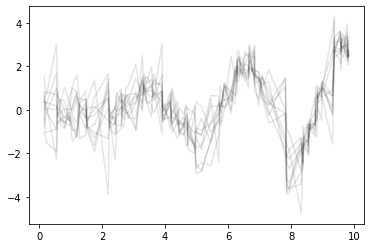

In [36]:
particle_paths = np.array(pf.hist.X)
axis = 0
cis = np.percentile(particle_paths[:,:,axis],[2.5,50,97.5],axis=1)
plt.plot(obstimes, particle_paths[:,::100,axis],'k-',alpha=0.1);

In [37]:
smooth_trajectories = pf.hist.backward_sampling(100)
strajs = np.array(smooth_trajectories)

I think one of the main concerns is the lack of 'spread' in the particles? (esp after smoothing).

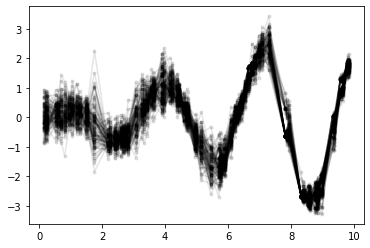

In [38]:
plt.plot(obstimes, strajs[:,:,1],'.-k',alpha=0.1);

In [39]:
#uncomment to plot with filter outputs
#strajs = np.array(pf.hist.X)

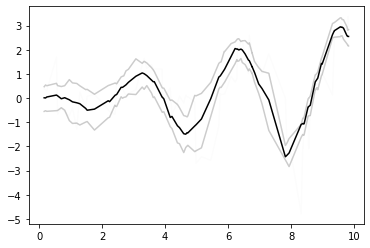

In [40]:
axis = 0
cis = np.percentile(strajs[:,:,axis],[2.5,50,97.5],axis=1)
plt.plot(obstimes, particle_paths[:,::1000,0],'k-',alpha=0.01);
plt.plot(obstimes, cis[0],'k-',alpha=0.2);
plt.plot(obstimes, cis[1],'k-',alpha=1);
plt.plot(obstimes, cis[2],'k-',alpha=0.2);
#plt.plot(obstimes, np.mean(particle_paths[:,:,axis],1),'r-',alpha=1);

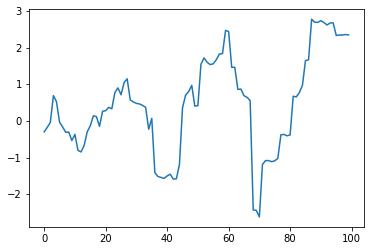

In [85]:
plt.plot(p[:,0])

In [97]:
np.linalg.norm(qend-qstart)

0.16202102837512716

SyntaxError: unexpected EOF while parsing (<ipython-input-107-39ac7e204c8d>, line 1)

In [116]:
for a,b,c in zip(*[np.linspace(qstart[i],qend[i],int(10*np.linalg.norm(qend-qstart))) for i in range(3)]):
    print(a,b,c)

-0.2971331375632237 -0.10593907818694652 0.6220215370320865


In [124]:
drawvol = np.zeros([100,100,100])
for p in strajs.transpose([1,0,2]):
    for qstart,qend in zip(p[:-1],p[1:]):
        for posx,posy,posz in zip(*[np.linspace(qstart[i],qend[i],int(10*np.linalg.norm(qend-qstart))) for i in range(3)]):
            volcoord = ((np.array([posx,posy,posz]) + np.array([5,5,0]))*(100/10)).astype(int)
            if np.any(volcoord<0): continue
            drawvol[volcoord[0],volcoord[1],volcoord[2]]+=1

In [120]:
for p in strajs.transpose([1,0,2]):
    for pos in zip(np.arange(p[0,0],p[0,1],0.1),np.arange(p[0,0],p[0,1],0.1),np.arange(p[0,0],p[0,1],0.1))
    for q in p:
        volcoord = ((q + np.array([5,5,0]))*(100/10)).astype(int)
        if np.any(volcoord<0): continue
        drawvol[volcoord[0],volcoord[1],volcoord[2]]+=1

SyntaxError: invalid syntax (<ipython-input-120-4f5eca65ab73>, line 3)

In [126]:
ipv.quickvolshow(drawvol,extent=[[-5,5],[-5,5],[0,10]],data_max=1)#np.max(drawvol))

In [130]:
import numpy as np
import ipyvolume as ipv
ipv.clear()
ipv.plot(actual[:,0],actual[:,1],actual[:,2],color='black')
meanpath = np.mean(strajs,1)
ipv.plot(meanpath[:,0],meanpath[:,1],meanpath[:,2])
ipv.volshow(drawvol.transpose([2,1,0]),extent=[[-5,5],[-5,5],[0,10]],data_max=1)#np.max(drawvol))
#for i in range(0,10):#strajs.shape[1],1):
#    ipv.scatter(strajs[:,i,0],strajs[:,i,1],strajs[:,i,2],alpha=0.1,color='blue',size=1,marker='sphere')
ipv.xlim(-5,5)
ipv.ylim(-5,5)
ipv.zlim(0,10)
ipv.show()